# Признаки для объединенного датасета events_train.csv и events_data_test.csv

Импортируем библиотеки и делаем некоторые настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from collections import Counter

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
sns.set(rc={'figure.figsize': (17, 8)})
pd.set_option('display.max_columns', None)# вывод всех колонок фрейма

Загружаем данные о действиях, которые совершают студенты со стэпами

In [5]:
events = pd.read_csv('DATA\\events_all_two_days.zip', compression='zip')

Сводная таблица по всем категориям из action

In [6]:
first_data = events.pivot_table(index='user_id',
                                columns='action',
                                values='step_id',
                                aggfunc='count',
                                fill_value=0).reset_index()

In [7]:
#уберем индекс action
first_data.columns
first_data.columns.name
first_data.columns.name = None

Переименование колонок

In [8]:
first_data = first_data.rename(columns={'discovered': 'd_count',
                                        'passed': 'p_count',
                                        'started_attempt': 's_count',
                                        'viewed': 'v_count'})

Сводная таблица по всем категориям из action для уникальных step_id

In [9]:
second_data = events.pivot_table(index='user_id',
                                 columns='action',
                                 values='step_id',
                                 aggfunc='nunique',
                                 fill_value=0).reset_index()

In [10]:
#уберем индекс action
second_data.columns
second_data.columns.name
second_data.columns.name = None

In [11]:
second_data = second_data.rename(columns={'discovered': 'd_uniq',
                                          'passed': 'p_uniq',
                                          'started_attempt': 's_uniq',
                                          'viewed': 'v_uniq'})

Соединяем  активности уникальные и нет

In [12]:
first_data = first_data.merge(second_data, on='user_id', how='inner')

Добавим новые признаки

In [13]:
first_data['s_diff'] = first_data.s_count - first_data.s_uniq
first_data['v_diff'] = first_data.v_count - first_data.v_uniq
first_data['s_div'] = (first_data.s_count / first_data.s_uniq)
first_data['v_div'] = (first_data.v_count / first_data.v_uniq)

In [14]:
first_data = first_data.fillna(1)# Заполним пропуски на 1

Удалим повторяющиеся колонки

In [15]:
first_data = first_data.drop(['d_uniq', 'p_uniq'], axis=1)

Сделаем выборку всех step_id для каждого пользователя

In [16]:
user_steps = events.groupby('user_id').step_id.unique().to_frame() \
                   .reset_index().rename(columns={'step_id': 'steps_list'})

In [17]:
del events

Признак отношение суммы step_id к сумме step_id если-бы учашийся проходил их в "идеальном" порядке

In [18]:
# "идеальный" порядок step_id
ideal_steps = pd.read_csv('DATA\\ideal_steps_events_all.csv')

In [19]:
# сумма степов пользователя, дальше заполнил в цикле
user_steps['steps_sum'] = np.nan

In [20]:
for i in range(len(user_steps)):
    user_steps['steps_sum'][i] = sum(user_steps.steps_list[i])

In [21]:
# сумма степов "идеального" порядка, дальше заполнение
user_steps['ideal_steps_sum'] = np.nan

In [22]:
 for i in range(len(user_steps)):
    s = 0
    for j in range(len(user_steps.steps_list[i])):
         s = s + ideal_steps.step_id[j]
    user_steps['ideal_steps_sum'][i] = s

In [23]:
# признак
user_steps['steps_ratio'] = user_steps.steps_sum/user_steps.ideal_steps_sum

In [24]:
user_steps.steps_ratio.min(), user_steps.steps_ratio.max()

(0.7640348288318888, 4.8280664330336736)

Хитрый признак на основе степов. Загрузим его из файла, чтобы не пересчитывать

In [25]:
#user_steps['sum_diff'] = np.nan

In [26]:
#for i in range(len(user_steps)):# длится более 5 часов!
    #s = 0
    #p = 0
    #for j in range(len(user_steps.steps_list[i])):
        #for k in range(len(ideal_steps)):
            #if user_steps.steps_list[i][j] / ideal_steps.step_id[k] == 1:
                #s = s + abs(k - j) - p
                #p = s
    #user_steps['sum_diff'][i] = s
           
#user_steps.head(10)

In [27]:
# лучше не трогать, чтобы не ждать 5 часов!
#user_steps.to_csv('DATA\\feature_steps_events.zip', index=False,  compression='zip')

In [28]:
#загрузка сохраненного ранее признака
user_steps=pd.read_csv('DATA\\feature_steps_events.zip',compression='zip')

In [29]:
#удаляем ненужное
user_steps = user_steps.drop(['steps_list',
                              'steps_sum',
                              'ideal_steps_sum'], axis=1)

Добавляем признаки в общую таблицу

In [30]:
first_data = first_data.merge(user_steps, on='user_id', how='inner')

Загрузим признаки, основанные на распределении активности пользователей по времени суток

In [31]:
times_feature = pd.read_csv('DATA\\times_feature_events_all_NEW.csv')

In [32]:
first_data = first_data.merge(times_feature, on='user_id', how='inner')

Далее еще признаки:  
* количество пользователей с одинаковыми значениями p_count -  p_freq,  
* их отношение к количеству всех пользователей - p_density,  
* произведение колонок - p_count * steps_ratio,  
* отношение частот текущей к следующей на графике - p_freq[i] / p_freq[i+1],  
* признак относительных частот с весами - (p_freq[i]/p_freq[i+1]) * (p_count*steps_ratio)

In [33]:
p_dict = Counter(first_data.p_count)# словарик частот

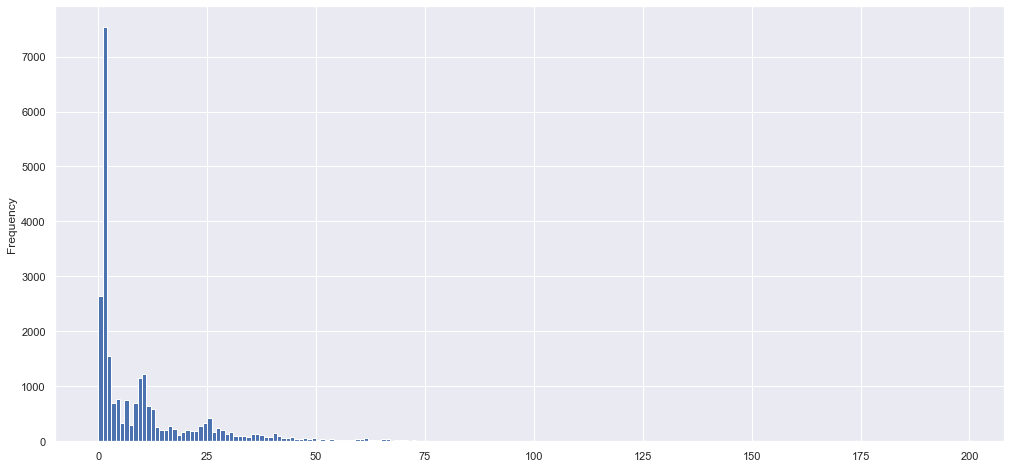

In [34]:
first_data.p_count.plot.hist(bins=198)# посмотрим на распрделение p_count

In [35]:
first_data['p_freq'] = np.nan# создаем новые колонки
first_data['p_density'] = np.nan

In [36]:
# частоты и плотности для значений столбца p_count
for i in range(len(first_data)):
    first_data['p_freq'][i] = p_dict.get(first_data.p_count[i])
    first_data['p_density'][i] = p_dict.get(first_data.p_count[i]) / 25418

In [37]:
# произведение признаков тоже признак
first_data['p_count*steps_ratio']=first_data.p_count*first_data.steps_ratio

In [38]:
# создаем вспомогательный столбец
first_data['p_freq[i+1]'] = np.nan

In [39]:
# и заполняем его
for i in range(len(first_data)):
    first_data['p_freq[i+1]'][i] = p_dict.get((first_data.p_count[i] + 1))

In [40]:
# признак - отношение частот текущей к следующей на графике
first_data['p_freq[i]/p_freq[i+1]'] = first_data['p_freq'] / first_data['p_freq[i+1]']

In [41]:
# теперь удалим вспомогательный столбец
first_data = first_data.drop(['p_freq[i+1]'], axis=1)

In [42]:
# посмотрим на строки, содержащих null
#first_data[first_data.isnull().any(axis=1)]

In [43]:
# пропуски заменим на 1 для редких частот
first_data = first_data.fillna(1)

In [44]:
# наконец, признак относительных частот с весами
first_data['(p_freq[i]/p_freq[i+1])*(p_count*steps_ratio)'] = first_data['p_freq[i]/p_freq[i+1]'] * first_data['p_count*steps_ratio']

Сохраним результаты в файл:

In [45]:
first_data.to_csv('DATA\\feature_data_events_22.zip', index=False,  compression='zip')

In [46]:
display(first_data)

,user_id,d_count,p_count,s_count,v_count,s_uniq,v_uniq,s_diff,v_diff,s_div,v_div,steps_ratio,sum_diff,steps_day,steps_night,day_ratio,hours_sum,hours_ratio,p_freq,p_density,p_count*steps_ratio,p_freq[i]/p_freq[i+1],(p_freq[i]/p_freq[i+1])*(p_count*steps_ratio)
0,1,1,0,0,1,0,1,0,0,1.0,1.000000,0.974585,53.0,2.0,0.0,1.0,1,0.020408,2640.0,0.103863,0.000000,0.350365,0.000000
1,2,9,9,2,9,2,9,0,0,1.0,1.000000,1.000000,0.0,31.0,0.0,1.0,1,0.020408,1154.0,0.045401,9.000000,0.942810,8.485294
2,3,15,15,4,20,4,15,0,5,1.0,1.333333,0.846088,1.0,62.0,0.0,1.0,2,0.040816,198.0,0.007790,12.691324,0.717391,9.104645
3,4,1,1,0,1,0,1,0,0,1.0,1.000000,1.000000,0.0,3.0,0.0,1.0,1,0.020408,7535.0,0.296443,1.000000,4.836329,4.836329
4,5,1,1,0,1,0,1,0,0,1.0,1.000000,0.980984,9.0,7.0,0.0,1.0,2,0.040816,7535.0,0.296443,0.980984,4.836329,4.744362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25413,26796,6,4,2,12,2,6,0,6,1.0,2.000000,1.000000,0.0,29.0,0.0,1.0,2,0.040816,762.0,0.029979,4.000000,2.295181,9.180723
25414,26797,10,10,2,10,2,10,0,0,1.0,1.000000,1.000000,0.0,34.0,0.0,1.0,1,0.020408,1224.0,0.048155,10.000000,1.924528,19.245283
25415,26798,12,12,3,12,2,12,1,0,1.5,1.000000,1.000000,0.0,0.0,42.0,0.0,2,0.040816,586.0,0.023055,12.000000,2.325397,27.904762
25416,26799,6,6,2,6,2,6,0,0,1.0,1.000000,1.000000,0.0,22.0,0.0,1.0,2,0.040816,757.0,0.029782,6.000000,2.514950,15.089701


In [47]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25418 entries, 0 to 25417
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   user_id                                        25418 non-null  int64  
 1   d_count                                        25418 non-null  int64  
 2   p_count                                        25418 non-null  int64  
 3   s_count                                        25418 non-null  int64  
 4   v_count                                        25418 non-null  int64  
 5   s_uniq                                         25418 non-null  int64  
 6   v_uniq                                         25418 non-null  int64  
 7   s_diff                                         25418 non-null  int64  
 8   v_diff                                         25418 non-null  int64  
 9   s_div                                          254